In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
with gzip.open('../data/chembl_5HT.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


Get some info about those assays:

In [3]:
import requests,json
assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('target_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/target/{k}?format=json')
    info = json.loads(resp.text)
    assay_lookup[k] = info['organism'],info['pref_name']
    print(k,v,info['organism'],info['pref_name'])

CHEMBL3371 3180 Homo sapiens Serotonin 6 (5-HT6) receptor
CHEMBL224 3068 Homo sapiens Serotonin 2a (5-HT2a) receptor
CHEMBL214 2672 Homo sapiens Serotonin 1a (5-HT1a) receptor
CHEMBL3155 1636 Homo sapiens Serotonin 7 (5-HT7) receptor
CHEMBL225 1580 Homo sapiens Serotonin 2c (5-HT2c) receptor
CHEMBL1833 922 Homo sapiens Serotonin 2b (5-HT2b) receptor
CHEMBL1898 542 Homo sapiens Serotonin 1b (5-HT1b) receptor
CHEMBL1983 525 Homo sapiens Serotonin 1d (5-HT1d) receptor
CHEMBL1899 491 Homo sapiens Serotonin 3a (5-HT3a) receptor
CHEMBL1875 369 Homo sapiens Serotonin 4 (5-HT4) receptor
CHEMBL3426 227 Homo sapiens Serotonin 5a (5-HT5a) receptor
CHEMBL2182 86 Homo sapiens Serotonin 1e (5-HT1e) receptor
CHEMBL1805 36 Homo sapiens Serotonin 1f (5-HT1f) receptor


Look at some distributions of activities

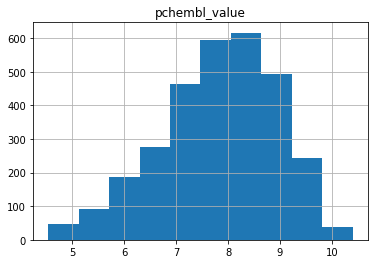

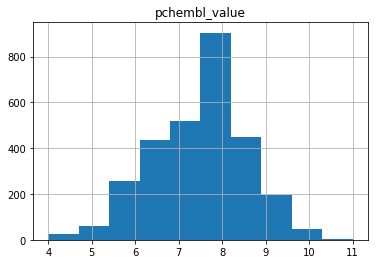

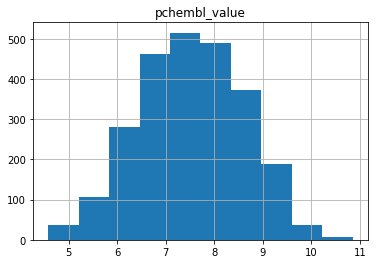

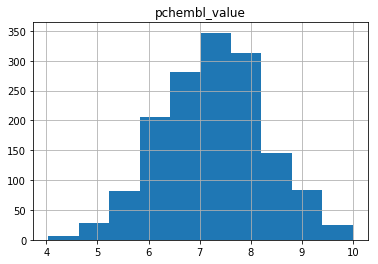

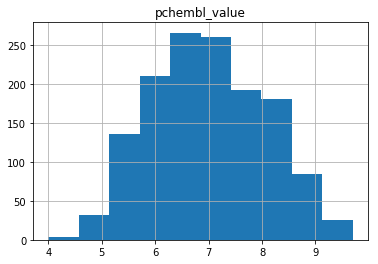

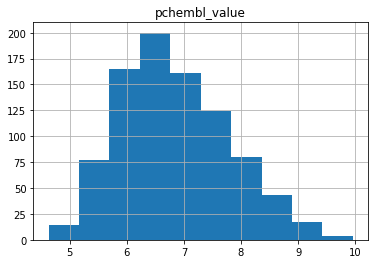

In [73]:
for v,k in tpls:
    if v>900:
        d.loc[d['target_chembl_id']==k].hist('pchembl_value');
        

Here's the function to build an evaluation a random forest for an assay. It's not the greatest model ever, but that's beside the point for this analysis

In [2]:
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def run_it(acts,inacts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))


    inact_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    random.seed(0xf00d)
    nAct = len(act_data)
    actis = list(range(nAct))
    nInact = len(inact_data)
    inactis = list(range(nInact))
    random.shuffle(actis)
    random.shuffle(inactis)

    train_pct = 0.80
    train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
    test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

    random.shuffle(train)
    random.shuffle(test)

    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
    cls.fit([y for x,y,z in train],[z for x,y,z in train])
    scores = cls.predict([y for x,y,z in test])
    probs = cls.predict_proba([y for x,y,z in test])[:,1]
    auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
    print('ratio: %.3f kappa: %.3f, AUC: %.3f'%(nAct/nInact,metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc))
    print(metrics.confusion_matrix([z for x,y,z in test],scores))
    print(metrics.classification_report([z for x,y,z in test],scores))
    return probs,[z for x,y,z in test]

In [4]:
def run_assay(assay_id,d,assay_lookup,thresholds=[0.3]):
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)<50:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    else:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    print("--------- Default -----------")
    ps,tgt = run_it(acts,inacts)
    print("--------- Balanced -----------")
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        print('thresh: %.3f kappa: %.3f'%(thresh,metrics.cohen_kappa_score(tgt,scores)))
        print(metrics.confusion_matrix(tgt,scores))
        print(metrics.classification_report(tgt,scores))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [77]:
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def run_it2(acts,inacts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))


    inact_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    random.seed(0xf00d)
    nAct = len(act_data)
    actis = list(range(nAct))
    nInact = len(inact_data)
    inactis = list(range(nInact))
    random.shuffle(actis)
    random.shuffle(inactis)

    train_pct = 0.80
    train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
    test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

    random.shuffle(train)
    random.shuffle(test)

    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4,oob_score=True)
    cls.fit([y for x,y,z in train],[z for x,y,z in train])
    scores = cls.predict([y for x,y,z in test])
    probs = cls.predict_proba([y for x,y,z in test])[:,1]
    auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
    print('ratio: %.3f kappa: %.3f, AUC: %.3f'%(nAct/nInact,metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc))
    print(metrics.confusion_matrix([z for x,y,z in test],scores))
    print(metrics.classification_report([z for x,y,z in test],scores))
    return probs,[z for x,y,z in test],([z for x,y,z in train],cls.oob_decision_function_)

In [109]:
from collections import defaultdict
def run_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)<50:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    else:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    print("--------- Default -----------")
    ps,tgt,oob_tpl = run_it2(acts,inacts)
    auroc = metrics.roc_auc_score(tgt, ps)
    scores = [1 if x>=0.5 else 0 for x in ps]
    kappa = metrics.cohen_kappa_score(tgt,scores)
    confusion = metrics.confusion_matrix(tgt,scores)
    archive[assay_id].append((0.5,kappa,confusion,auroc))

    print("--------- Balanced -----------")
    if thresholds is None:
        threshs = np.arange(0.05,0.1,0.55,0.05)
        tscores = []
        oob_tgt,oob_probs = oob_tpl
        oob_probs = [x[1] for x in oob_probs]
        for thresh in threshs:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(oob_tgt,scores)
            tscores.append((np.round(kappa,3),thresh))
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
        thresholds = [thresh]
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        kappa = metrics.cohen_kappa_score(tgt,scores)
        confusion = metrics.confusion_matrix(tgt,scores)
        archive[assay_id].append((thresh,kappa,confusion,None))
        print('thresh: %.3f kappa: %.3f'%(thresh,kappa))
        print(confusion)        
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [27]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_assay(k,d,assay_lookup,archive=serotonin_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
ratio: 0.189 kappa: 0.606, AUC: 0.967
[[417  11]
 [ 36  45]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95       428
          1       0.80      0.56      0.66        81

avg / total       0.90      0.91      0.90       509

--------- Balanced -----------
thresh: 0.300 kappa: 0.788
[[409  19]
 [ 11  70]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL224, organism: Homo sapiens, target: Serotonin 2a (5-HT2a) receptor
--------- Default -----------
ratio: 0.085 kappa: 0.726, AUC: 0.987
[[495   1]
 [ 17  26]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       496
          1       0.96      0.60      0.74        43

avg / total       0.97      0.97

In [10]:
import glob
datasets = glob.glob('../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list*_actives.dat.gz')
print(len(datasets))
random.seed(0xf00d)
random.shuffle(datasets)
keep = datasets[:20]
keep[:5]

80


['../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_10198_actives.dat.gz',
 '../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_10980_actives.dat.gz',
 '../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_11279_actives.dat.gz',
 '../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_87_actives.dat.gz',
 '../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_12252_actives.dat.gz']

In [30]:
import re
with gzip.open('../../Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz') as inf:
    inactive_df = pd.read_csv(inf,sep='\t')

chembl_active_sets = {}
for fn in datasets:
    nm = re.search(r'cmp_list_(ChEMBL_[0-9]*)_actives',fn).groups()[0]
    with gzip.open(fn) as inf:
        chembl_active_sets[nm] = pd.read_csv(inf,sep='\t')

In [31]:
chembl_active_sets.keys()

dict_keys(['ChEMBL_10198', 'ChEMBL_10980', 'ChEMBL_11279', 'ChEMBL_87', 'ChEMBL_12252', 'ChEMBL_10280', 'ChEMBL_17045', 'ChEMBL_10188', 'ChEMBL_10193', 'ChEMBL_11365', 'ChEMBL_93', 'ChEMBL_10773', 'ChEMBL_10417', 'ChEMBL_36', 'ChEMBL_134', 'ChEMBL_20014', 'ChEMBL_114', 'ChEMBL_12209', 'ChEMBL_25', 'ChEMBL_11359', 'ChEMBL_51', 'ChEMBL_10927', 'ChEMBL_10475', 'ChEMBL_11631', 'ChEMBL_10434', 'ChEMBL_10378', 'ChEMBL_116', 'ChEMBL_61', 'ChEMBL_12261', 'ChEMBL_11085', 'ChEMBL_20174', 'ChEMBL_19905', 'ChEMBL_11575', 'ChEMBL_11336', 'ChEMBL_52', 'ChEMBL_11536', 'ChEMBL_108', 'ChEMBL_107', 'ChEMBL_130', 'ChEMBL_100126', 'ChEMBL_11534', 'ChEMBL_15', 'ChEMBL_11265', 'ChEMBL_12911', 'ChEMBL_276', 'ChEMBL_12679', 'ChEMBL_11489', 'ChEMBL_12670', 'ChEMBL_13001', 'ChEMBL_10579', 'ChEMBL_11682', 'ChEMBL_8', 'ChEMBL_43', 'ChEMBL_90', 'ChEMBL_126', 'ChEMBL_219', 'ChEMBL_104', 'ChEMBL_121', 'ChEMBL_11488', 'ChEMBL_18061', 'ChEMBL_28', 'ChEMBL_12968', 'ChEMBL_12952', 'ChEMBL_10498', 'ChEMBL_72', 'ChEMBL_23

In [28]:
from collections import defaultdict
def run_dataset1_assay(assay_id,chembl_active_sets,inactive_df,factor=20,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = chembl_active_sets[assay_id]
    acts = assay.rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})
    inacts = inactive_df.sample(n=factor*len(acts),random_state=hash(assay_id)%0xf00d).rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}')
    print("--------- Default -----------")
    ps,tgt,oob_tpl = run_it2(acts,inacts)
    auroc = metrics.roc_auc_score(tgt, ps)
    scores = [1 if x>=0.5 else 0 for x in ps]
    kappa = metrics.cohen_kappa_score(tgt,scores)
    confusion = metrics.confusion_matrix(tgt,scores)
    archive[assay_id].append((0.5,kappa,confusion,auroc))
    print("--------- Balanced -----------")
    if thresholds is None:
        threshs = np.arange(0.1,0.55,0.05)
        tscores = []
        oob_tgt,oob_probs = oob_tpl
        oob_probs = [x[1] for x in oob_probs]
        for thresh in threshs:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(oob_tgt,scores)
            tscores.append((np.round(kappa,3),thresh))
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
        thresholds = [thresh]
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        kappa = metrics.cohen_kappa_score(tgt,scores)
        confusion = metrics.confusion_matrix(tgt,scores)
        archive[assay_id].append((thresh,kappa,confusion,None))
        print('thresh: %.3f kappa: %.3f'%(thresh,kappa))
        print(confusion)        
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [32]:
ds1_archive = defaultdict(list)
for k in chembl_active_sets:
    run_dataset1_assay(k,chembl_active_sets,inactive_df,archive=ds1_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10198
--------- Default -----------
ratio: 0.050 kappa: 0.656, AUC: 1.000
[[400   0]
 [ 10  10]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.50      0.67        20

avg / total       0.98      0.98      0.97       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10980
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.991
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.802
[[398   2]
 [  5  15]]
*-*-*-*-*-*-*-*-*-

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.741, AUC: 0.967
[[400   0]
 [  8  12]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.60      0.75        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_87
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.895
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.307
[[399   1]
 [ 16   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_1

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.252, AUC: 0.984
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.791
[[399   1]
 [  6  14]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10280
--------- Default -----------
ratio: 0.050 kappa: 0.252, AUC: 0.985
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.843
[[397   3]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.941
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.780
[[400   0]
 [  7  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10193
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.252, AUC: 0.977
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.746
[[397   3]
 [  6  14]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11365
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.921
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.536
[[394   6]
 [ 10  10]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.252, AUC: 0.991
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.672
[[397   3]
 [  8  12]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10773
--------- Default -----------
ratio: 0.050 kappa: 0.741, AUC: 1.000
[[400   0]
 [  8  12]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.60      0.75        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.200 kappa: 1.000
[[400   0]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

ratio: 0.050 kappa: 0.700, AUC: 0.998
[[400   0]
 [  9  11]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.55      0.71        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_61
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.963
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.100 kappa: 0.491
[[383  17]
 [  7  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_1

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.506, AUC: 0.954
[[400   0]
 [ 13   7]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       400
          1       1.00      0.35      0.52        20

avg / total       0.97      0.97      0.96       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.915
[[400   0]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11336
--------- Default -----------
ratio: 0.050 kappa: 0.700, AUC: 1.000
[[400   0]
 [  9  11]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.55      0.71        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.816, AUC: 1.000
[[400   0]
 [  6  14]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       400
          1       1.00      0.70      0.82        20

avg / total       0.99      0.99      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.950
[[398   2]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_108
--------- Default -----------
ratio: 0.050 kappa: 0.000, AUC: 0.960
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.528
[[396   4]
 [ 11   9]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.952
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.633
[[397   3]
 [  9  11]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_130
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.091, AUC: 0.951
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.669
[[395   5]
 [  7  13]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100126
--------- Default -----------
ratio: 0.050 kappa: 0.780, AUC: 0.983
[[400   0]
 [  7  13]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.65      0.79        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.884
[[400   0]
 [  4  16]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEM

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.323, AUC: 0.976
[[400   0]
 [ 16   4]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.20      0.33        20

avg / total       0.96      0.96      0.95       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.768
[[398   2]
 [  6  14]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11265
--------- Default -----------
ratio: 0.050 kappa: 0.973, AUC: 1.000
[[400   0]
 [  1  19]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       400
          1       1.00      0.95      0.97        20

avg / total       1.00      1.00      1.00       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.974
[[399   1]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.780, AUC: 0.999
[[400   0]
 [  7  13]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.65      0.79        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12679
--------- Default -----------
ratio: 0.050 kappa: 0.945, AUC: 1.000
[[400   0]
 [  2  18]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       400
          1       1.00      0.90      0.95        20

avg / total       1.00      1.00      1.00       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.973
[[400   0]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.091, AUC: 0.991
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.872
[[397   3]
 [  2  18]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_13001
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.926
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.676
[[399   1]
 [  9  11]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.993
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.633
[[399   1]
 [ 10  10]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_121
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.000, AUC: 0.970
[[400   0]
 [ 20   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       0.00      0.00      0.00        20

avg / total       0.91      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.613
[[396   4]
 [  9  11]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11488
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.915, AUC: 0.999
[[400   0]
 [  3  17]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       400
          1       1.00      0.85      0.92        20

avg / total       0.99      0.99      0.99       420

--------- Balanced -----------
thresh: 0.250 kappa: 0.948
[[399   1]
 [  1  19]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_18061
--------- Default -----------
ratio: 0.050 kappa: 0.449, AUC: 0.985
[[400   0]
 [ 14   6]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       400
          1       1.00      0.30      0.46        20

avg / total       0.97      0.97      0.96       420

--------- Balanced -----------
thresh: 0.200 kappa: 0.915
[[400   0]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.252, AUC: 0.982
[[400   0]
 [ 17   3]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       400
          1       1.00      0.15      0.26        20

avg / total       0.96      0.96      0.94       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.699
[[393   7]
 [  5  15]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11442
--------- Default -----------
ratio: 0.050 kappa: 0.915, AUC: 1.000
[[400   0]
 [  3  17]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       400
          1       1.00      0.85      0.92        20

avg / total       0.99      0.99      0.99       420

--------- Balanced -----------
thresh: 0.200 kappa: 1.000
[[400   0]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.050 kappa: 0.741, AUC: 0.999
[[400   0]
 [  8  12]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       400
          1       1.00      0.60      0.75        20

avg / total       0.98      0.98      0.98       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.904
[[396   4]
 [  0  20]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10260
--------- Default -----------
ratio: 0.050 kappa: 0.091, AUC: 0.993
[[400   0]
 [ 19   1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       400
          1       1.00      0.05      0.10        20

avg / total       0.96      0.95      0.93       420

--------- Balanced -----------
thresh: 0.150 kappa: 0.915
[[400   0]
 [  3  17]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMB

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
list(ds1_archive.values())[0]

[(0.5, 0.6557377049180328, array([[400,   0],
         [ 10,  10]]), 0.9998750000000001),
 (0.15000000000000002, 0.9731113956466069, array([[400,   0],
         [  1,  19]]), None)]

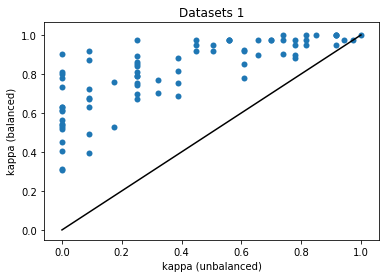

In [46]:
initVs = [x[0][1] for x in ds1_archive.values()]
finalVs = [x[1][1] for x in ds1_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('Datasets 1');

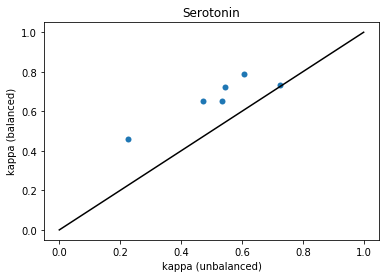

In [47]:
initVs = [x[0][1] for x in serotonin_archive.values()]
finalVs = [x[1][1] for x in serotonin_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('Serotonin');

# PubChem HTS Validation assays found in ChEMBL

In [53]:
with gzip.open('../data/ChEMBL_PubChem_HTS.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.Br.C(c1ccncc1)c2cnc[nH]2,CHEMBL1316355,CHEMBL1614421,=,44668.4,Inconclusive
1,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614249,=,31622.8,Not Active
2,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614364,=,446.7,Not Active
3,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614421,=,17782.8,Inconclusive
4,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1794375,NaN,35481.3,active


In [54]:
import requests,json
pubchem_assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('assay_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/assay/{k}?format=json')
    info = json.loads(resp.text)
    pubchem_assay_lookup[k] = info['description']
    print(k,v,info['description'])

CHEMBL1794375 83178 PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
CHEMBL1614421 49035 PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]
CHEMBL1614249 42030 PUBCHEM_BIOASSAY: qHTS Assay for Identification of Novel General Anesthetics. In this assay, a GABAergic mimetic model system, apoferritin and a profluorescent 1-aminoanthracene ligand (1-AMA), was used to construct a competitive binding assay for identification of novel general anesthetics (Class of assay: confirmatory) [Related pubchem assays: 2385 (Probe Development Summary for Identification of Novel General Anesthetics), 2323 (Validation apoferritin assay run on SigmaAldrich LOPAC1280 collection)]
CHEMBL1614166 34201 PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA bi

In [86]:
from collections import defaultdict
def run_pubchem_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = d.loc[d['assay_chembl_id']==assay_id]
    acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                      assay.loc[assay['activity_comment'] == 'active']))
    inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                        assay.loc[assay['activity_comment'] == 'inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Not Active']))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    print(len(acts),len(inacts),len(assay))
    print("--------- Default -----------")
    ps,tgt,oob_tpl = run_it2(acts,inacts)
    auroc = metrics.roc_auc_score(tgt, ps)
    scores = [1 if x>=0.5 else 0 for x in ps]
    kappa = metrics.cohen_kappa_score(tgt,scores)
    confusion = metrics.confusion_matrix(tgt,scores)
    archive[assay_id].append((0.5,kappa,confusion,auroc))

    print("--------- Balanced -----------")
    if thresholds is None:
        threshs = np.arange(0.1,0.55,0.05)
        tscores = []
        oob_tgt,oob_probs = oob_tpl
        oob_probs = [x[1] for x in oob_probs]
        for thresh in threshs:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(oob_tgt,scores)
            tscores.append((np.round(kappa,3),thresh))
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
        thresholds = [thresh]
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        kappa = metrics.cohen_kappa_score(tgt,scores)
        confusion = metrics.confusion_matrix(tgt,scores)
        archive[assay_id].append((thresh,kappa,confusion,None))
        print('thresh: %.3f kappa: %.3f'%(thresh,kappa))
        print(confusion)        
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [89]:
pubchem_archive = defaultdict(list)
for k in pubchem_assay_lookup:
    run_pubchem_assay(k,d,pubchem_assay_lookup,archive=pubchem_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1794375, description: PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
4488 78690 83178
--------- Default -----------
ratio: 0.057 kappa: 0.002, AUC: 0.706
[[15737     1]
 [  897     1]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     15738
          1       0.50      0.00      0.00       898

avg / total       0.92      0.95      0.92     16636

--------- Balanced -----------
thresh: 0.100 kappa: 0.128
[[15560   178]
 [  811    87]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614421, description: PUBCHEM_BIOASSAY: qHTS for Inhibitors of Tau Fibril Formation, Thioflavin T Binding. (Class of assay: confirmatory) [Related pubchem assays: 596 ]

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


thresh: 0.100 kappa: 0.119
[[8345   11]
 [  47    4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614166, description: PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA binding.   (Class of assay: confirmatory) 
98 34103 34201
--------- Default -----------
ratio: 0.003 kappa: 0.181, AUC: 0.903
[[6821    0]
 [  18    2]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6821
          1       1.00      0.10      0.18        20

avg / total       1.00      1.00      1.00      6841

--------- Balanced -----------
thresh: 0.100 kappa: 0.513
[[6815    6]
 [  11    9]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614364, description: PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of Tyrosyl-DNA Phosphodiesterase (TDP1). (Class of assay: confirmatory) 
925 10917 11842

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.257 kappa: 0.122, AUC: 0.811
[[695   5]
 [164  16]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89       700
          1       0.76      0.09      0.16       180

avg / total       0.80      0.81      0.74       880

--------- Balanced -----------
thresh: 0.250 kappa: 0.411
[[613  87]
 [ 83  97]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3215169, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Lassa Virus.   (Class of assay: confirmatory) 
575 2673 3248
--------- Default -----------
ratio: 0.215 kappa: 0.241, AUC: 0.739
[[531   4]
 [ 95  20]]
             precision    recall  f1-score   support

          0       0.85      0.99      0.91       535
          1       0.83      0.17      0.29       115

avg / total       0.85      0.85      0.80       650

--------- Balanced -----------
thresh: 0.200 kappa: 0.30

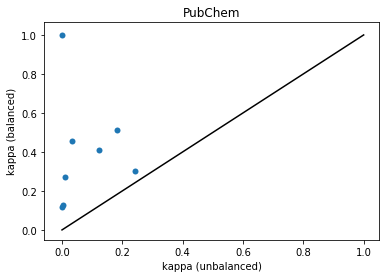

In [90]:
initVs = [x[0][1] for x in pubchem_archive.values()]
finalVs = [x[1][1] for x in pubchem_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('PubChem');

# ChEMBL DrugMatrix assays

In [91]:
with gzip.open('../data/ChEMBL_DrugMatrix.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
1,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
2,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
3,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
4,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909213,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...


In [123]:
import requests,json
drugmatrix_assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('assay_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    # we will only keep the subset of assays that have enough actives,
    assay = d.loc[d['assay_chembl_id']==k]
    if(len([1 for y in assay['activity_comment'] if y.find('as Active')>0])<40):
        #print(f'Skipping assay: {k}')
        continue
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/assay/{k}?format=json')
    info = json.loads(resp.text)
    drugmatrix_assay_lookup[k] = info['description']
    print(k,v,info['description'])

CHEMBL1909203 1644 DRUGMATRIX: Protein Tyrosine Kinase, EGF Receptor enzyme inhibition (substrate: Poly(Glu:Tyr))
CHEMBL1909132 1644 DRUGMATRIX: CYP450, 1A2 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
CHEMBL1909165 1641 DRUGMATRIX: Lipoxygenase 15-LO enzyme inhibition (substrate: Linoleic acid)
CHEMBL1909130 1639 DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibition (substrate: Arachidonic acid)
CHEMBL1909134 1636 DRUGMATRIX: CYP450, 2C19 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
CHEMBL1909135 1634 DRUGMATRIX: CYP450, 2C9 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
CHEMBL1909204 1632 DRUGMATRIX: Protein Tyrosine Kinase, Fyn enzyme inhibition (substrate: Poly(Glu:Tyr))
CHEMBL1909136 1611 DRUGMATRIX: CYP450, 2D6 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)


In [118]:
from collections import defaultdict
def run_drugmatrix_assay(assay_id,d,assay_lookup,thresholds=None,archive=None):
    if archive is None:
        archive=defaultdict(list)
    assay = d.loc[d['assay_chembl_id']==assay_id]
    inact_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Not Active')==0]
    act_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('as Active')>0]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')

    if(len(act_indices)<40):
        print(f'>>>>> SKIPPING {assay_id} DUE TO INSUFFICIENT ACTIVES <<<<<< ')
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')
        return

    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    print(len(act_indices),len(inact_indices),len(assay))
    acts = assay.iloc[act_indices]
    inacts = assay.iloc[inact_indices]
    print("--------- Default -----------")
    ps,tgt,oob_tpl = run_it2(acts,inacts)
    auroc = metrics.roc_auc_score(tgt, ps)
    scores = [1 if x>=0.5 else 0 for x in ps]
    kappa = metrics.cohen_kappa_score(tgt,scores)
    confusion = metrics.confusion_matrix(tgt,scores)
    archive[assay_id].append((0.5,kappa,confusion,auroc))

    print("--------- Balanced -----------")
    if thresholds is None:
        threshs = np.arange(0.1,0.55,0.05)
        tscores = []
        oob_tgt,oob_probs = oob_tpl
        oob_probs = [x[1] for x in oob_probs]
        for thresh in threshs:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(oob_tgt,scores)
            tscores.append((np.round(kappa,3),thresh))
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
        thresholds = [thresh]
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        kappa = metrics.cohen_kappa_score(tgt,scores)
        confusion = metrics.confusion_matrix(tgt,scores)
        archive[assay_id].append((thresh,kappa,confusion,None))
        print('thresh: %.3f kappa: %.3f'%(thresh,kappa))
        print(confusion)        
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [124]:
drugmatrix_archive = defaultdict(list)
for k in drugmatrix_assay_lookup:
    run_drugmatrix_assay(k,d,drugmatrix_assay_lookup,archive=drugmatrix_archive)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909203, description: DRUGMATRIX: Protein Tyrosine Kinase, EGF Receptor enzyme inhibition (substrate: Poly(Glu:Tyr))
40 1604 1644
--------- Default -----------
ratio: 0.025 kappa: 0.000, AUC: 0.935
[[321   0]
 [  8   0]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       321
          1       0.00      0.00      0.00         8

avg / total       0.95      0.98      0.96       329

--------- Balanced -----------
thresh: 0.100 kappa: 0.296
[[313   8]
 [  5   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909132, description: DRUGMATRIX: CYP450, 1A2 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
40 1604 1644
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.025 kappa: 0.000, AUC: 0.812
[[321   0]
 [  8   0]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       321
          1       0.00      0.00      0.00         8

avg / total       0.95      0.98      0.96       329

--------- Balanced -----------
thresh: 0.100 kappa: 0.457
[[316   5]
 [  4   4]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909165, description: DRUGMATRIX: Lipoxygenase 15-LO enzyme inhibition (substrate: Linoleic acid)
43 1598 1641
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.027 kappa: 0.000, AUC: 0.683
[[320   0]
 [  9   0]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       320
          1       0.00      0.00      0.00         9

avg / total       0.95      0.97      0.96       329

--------- Balanced -----------
thresh: 0.100 kappa: 0.263
[[311   9]
 [  6   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909130, description: DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibition (substrate: Arachidonic acid)
45 1594 1639
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.028 kappa: 0.000, AUC: 0.911
[[319   0]
 [  9   0]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       319
          1       0.00      0.00      0.00         9

avg / total       0.95      0.97      0.96       328

--------- Balanced -----------
thresh: 0.200 kappa: 0.174
[[318   1]
 [  8   1]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909134, description: DRUGMATRIX: CYP450, 2C19 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
48 1588 1636
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.030 kappa: 0.000, AUC: 0.808
[[318   0]
 [ 10   0]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       318
          1       0.00      0.00      0.00        10

avg / total       0.94      0.97      0.95       328

--------- Balanced -----------
thresh: 0.150 kappa: 0.360
[[315   3]
 [  7   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909135, description: DRUGMATRIX: CYP450, 2C9 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
50 1584 1634
--------- Default -----------


/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.032 kappa: 0.326, AUC: 0.883
[[317   0]
 [  8   2]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       317
          1       1.00      0.20      0.33        10

avg / total       0.98      0.98      0.97       327

--------- Balanced -----------
thresh: 0.250 kappa: 0.454
[[317   0]
 [  7   3]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909204, description: DRUGMATRIX: Protein Tyrosine Kinase, Fyn enzyme inhibition (substrate: Poly(Glu:Tyr))
52 1580 1632
--------- Default -----------
ratio: 0.033 kappa: 0.000, AUC: 0.791
[[316   0]
 [ 11   0]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       316
          1       0.00      0.00      0.00        11

avg / total       0.93      0.97      0.95       327

--------- Balanced -----------
thresh: 0.100 kappa: 0.388
[[304  12]
 [  5   6]]
*-*-*-*-*-

/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ratio: 0.047 kappa: 0.000, AUC: 0.834
[[308   0]
 [ 15   0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98       308
          1       0.00      0.00      0.00        15

avg / total       0.91      0.95      0.93       323

--------- Balanced -----------
thresh: 0.100 kappa: 0.320
[[291  17]
 [  8   7]]
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




/home/glandrum/anaconda5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


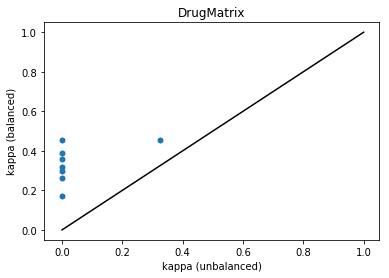

In [125]:
initVs = [x[0][1] for x in drugmatrix_archive.values()]
finalVs = [x[1][1] for x in drugmatrix_archive.values()]
plt.scatter(initVs,finalVs,linewidth=0);
plt.plot([0,1],[0,1],'k-')
plt.xlabel('kappa (unbalanced)')
plt.ylabel('kappa (balanced)')
plt.title('DrugMatrix');